# Problem Set 4, due '05/23/2017' at 3:30pm.

### Before You Start

This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set to make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions.
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 3.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import time

In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

---

## Part 1: Getting oriented

Use different learning rates

### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  Interpret your results.

In [3]:
# uncomment the following if you want to see a lengthy description of the dataset
print ("keys:", bdata.keys())
print ("feature names:",  bdata.feature_names)
print ("data shape:", bdata.data.shape)
print ("target shape", bdata.target.shape)
#print (bdata.DESCR)
print ("-"*80)

keys: dict_keys(['data', 'target', 'feature_names', 'DESCR'])
feature names: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
data shape: (506, 13)
target shape (506,)
--------------------------------------------------------------------------------


In [4]:
#Combine bdata data and target values into array
bdata_df = np.insert(bdata.data, bdata.data.shape[1],bdata.target, axis = 1)

In [5]:
#Linear regression 
#(a) regressing the housing price on the number of rooms per house
x = bdata_df[:, np.newaxis, 5]
y = bdata_df[:,np.newaxis, 13]

#Create linear regression object
lm1 = LinearRegression()
lm1.fit(x,y)

#Intercept
print('Intercept:', lm1.intercept_)
#Coefficient
print('Coefficient:', lm1.coef_)
#R-squared value
print('Coefficient of determination: %.2f' %lm1.score(x,y))

Intercept: [-34.67062078]
Coefficient: [[ 9.10210898]]
Coefficient of determination: 0.48


#### Interpretation
* An increase in 1 room per house is associated with an increase in the median housing price by $9102. 
* The intercept value of the linear regression is the median value of the house when no features are considered. A negative value for the intercept needs to be mean-centered for the interpretation to make sense. 
* The Coefficient of determination (R-squared) value = 0.48 implies the model explains 48 percent of the variability in the data.

In [6]:
#Linear Regression 
#(b) regressing the housing price on the number of rooms per house and the (number of rooms per house)squared.
x1 = bdata_df[:, np.newaxis, 5]
x2 = x1**2
x = np.append(x1, x2,1)
y = bdata_df[:,np.newaxis, 13]

#Create linear regression object
lm2 = LinearRegression()
lm2.fit(x,y)

#Intercept
print('Intercept:', lm2.intercept_)
#Coefficient
print('Coefficient:', lm2.coef_)
#R-squared value
print('Coefficient of determination: %.2f' %lm2.score(x,y))

Intercept: [ 66.05884748]
Coefficient: [[-22.64326237   2.47012384]]
Coefficient of determination: 0.55


#### Interpretation
* Due to the squared value of rooms per house, we now have a polynomial funtion which tries to better explain the model. An increase in 1 room per house is associated with an increase in the median housing price by $2470. 

* The intercept value of the linear regression is the median value of the house when no features are considered and is equal to $66058.
* The Coefficient of determination (R-squared) value = 0.55 implies the model explains 55 percent of the variability in the data which is an improvement to the earlier model of regressing housing proces on just the rooms per house.

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 250-fold cross-validation to fit regression (a) above, i.e. the linear fit of housing price on number of rooms per house.
Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the 250 slope coefficients, and draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you notice?

Note: please use 'random_state=1' and keep 'shuffle=False' when doing the KFold splitting to ensure reproducibility!

In [7]:
#Create data frame to store and display K-fold results
kfold_df = pd.DataFrame(columns=['K-Fold','Slope Coefficient','Intercept Coefficient'])
kfold_df['K-Fold']=range(1,251)

In [8]:
#K-Fold 
X = bdata_df[:, np.newaxis, 5]
y = bdata_df[:,np.newaxis, 13]

kf = KFold(n_splits = 250, random_state=1, shuffle=False)
fold = 0
slope = []
intercept = []
for train, test in kf.split(X):
    fold += 1
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    lm_kfold = LinearRegression().fit(X_train, y_train)
    intercept.append(float(lm_kfold.intercept_))
    slope.append(float(lm_kfold.coef_))  
    
#Adding results to dataframe
kfold_df['Slope Coefficient'] = slope
kfold_df['Intercept Coefficient'] = intercept

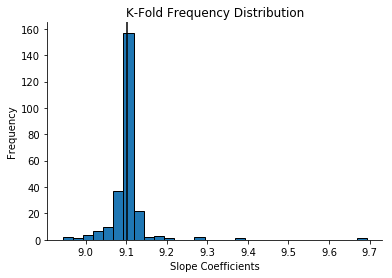

In [9]:
#Histogram
ax = plt.subplot(111)
ax.hist(kfold_df['Slope Coefficient'], bins= 30, edgecolor='black')
plt.axvline(lm1.coef_, color = 'k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Slope Coefficients')
plt.ylabel('Frequency')
plt.title('K-Fold Frequency Distribution')

#### What do you notice?
After cross-validation, it is observed that the estimate of the slope co-efficient is ~ 9.1 which is equal to the estimate obtained by linear regression on the entire dataset. This helps us verify that the model from linear regression is not overfitting the data.

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the two regression lines from 1.1 (or 1.2 if you prefer to do so). Show the linear regression line in red, and the linear+quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

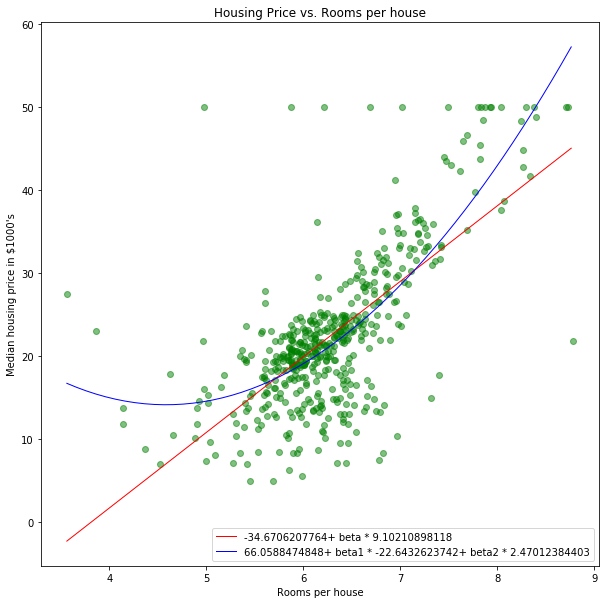

In [10]:
#Scatterplot of housing price on rooms per house
plt.figure(figsize=(10,10))
X = bdata_df[:, np.newaxis, 5]

# To obtain a smooth linear + quadratic regression line
X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
y = bdata_df[:,np.newaxis, 13]
plt.scatter(X,y, alpha=.5, color='green')
plt.plot(X_grid, lm1.predict(X_grid),label=str(lm1.intercept_[0])+ '+ beta * ' + str(lm1.coef_[0][0])  , color='red', linewidth=1)
plt.plot(X_grid, lm2.intercept_+(lm2.coef_[0][0]*X_grid)+(lm2.coef_[0][1]*X_grid**2), 
         label=str(lm2.intercept_[0])+ '+ beta1 * ' + str(lm2.coef_[0][0]) + '+ beta2 * ' + str(lm2.coef_[0][1]) , 
         color='blue', linewidth=1)
plt.xlabel('Rooms per house')
plt.ylabel('Median housing price in $1000\'s')
plt.title('Housing Price vs. Rooms per house')
plt.legend(loc = 'lower right')

## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (Average rooms per house)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: It is always useful to include maximum number of iterations, otherwise a rogue estimation may go on forever.*

In [13]:
"""
    Function
    --------
    bivariate_ols: Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

    Parameters
    ----------
    xvalues, yvalues : narray xvalues: independent variable; yvalues: dependent variable
    R: float, Learning rate
    MaxIterations: Int, maximum number of iterations

    Returns
    -------
    alpha: float, intercept
    beta: float, co-efficient
    ttaken: time taken
    it: number of iterations
    convergence: logical, convergence achieved?
"""

'\n    Function\n    --------\n    bivariate_ols: Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression\n\n    Parameters\n    ----------\n    xvalues, yvalues : narray xvalues: independent variable; yvalues: dependent variable\n    R: float, Learning rate\n    MaxIterations: Int, maximum number of iterations\n\n    Returns\n    -------\n    alpha: float, intercept\n    beta: float, co-efficient\n    ttaken: time taken\n    it: number of iterations\n    convergence: logical, convergence achieved?\n'

In [11]:
#Gradient descent wih one independent variable
def bivariate_ols(xvalues, yvalues, R, MaxIterations):
    start_time = time.time()
    xTrans = xvalues.transpose()
    n = len(xvalues)
    eps= 0.0001
    m = xvalues.shape[1]
    beta = np.zeros(m)
    prev = np.zeros(m+1)
    for i in range(0,MaxIterations):
        hypothesis = np.dot(xvalues, beta)
        loss = hypothesis - yvalues
        cost = np.sum(loss ** 2) / (2 * n)
        gradient = np.dot(xTrans, loss)/n
        beta = beta - R*gradient
        diff = prev - np.asarray([beta[0],beta[1], cost])
        if (abs(diff[0]) < eps and abs(diff[1]) < eps and abs(diff[2]) < eps):
            elapsed_time = time.time() - start_time
            return beta[0], beta[1], elapsed_time, i-1, True
        prev = np.asarray([beta[0],beta[1], cost])
        elapsed_time = round(time.time() - start_time,2)
    return(beta[0], beta[1], elapsed_time, i, False)

In [12]:
#Run the gradient descent algo for different R
xvalues = np.append(np.ones((bdata_df.shape[0],1)),bdata_df[:, np.newaxis, 5],1)
yvalues = bdata_df[:,13]
MaxIterations = 50000
R = [0.001,0.01,0.03, 0.05, 0.1]
for i in R:
    alpha, beta, ttaken, it, convergence = bivariate_ols(xvalues, yvalues, i, MaxIterations)
    if convergence == True:
        print('The gradient descent obtained for R: %.3f and MaxIterations: %d' %(i,MaxIterations))
        print('Alpha: %f' %alpha)
        print('Beta: %f' %beta)
        print('Time taken: %f' %ttaken)
        print('Iterations: %f' %it)
        print("Convergence:", convergence,"\n")
    else:
        print('Learning rate R: %.3f and MaxIterations: %d' %(i,MaxIterations))
        print('Gradient descent failed to converge\n')

Learning rate R: 0.001 and MaxIterations: 50000
Gradient descent failed to converge

The gradient descent obtained for R: 0.010 and MaxIterations: 50000
Alpha: -33.839101
Beta: 8.971390
Time taken: 1.656590
Iterations: 31155.000000
Convergence: True 

The gradient descent obtained for R: 0.030 and MaxIterations: 50000
Alpha: -34.393490
Beta: 9.058543
Time taken: 0.779856
Iterations: 13428.000000
Convergence: True 



C:\Users\vanlo\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in subtract
C:\Users\vanlo\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: overflow encountered in square
C:\Users\vanlo\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in subtract


Learning rate R: 0.050 and MaxIterations: 50000
Gradient descent failed to converge

Learning rate R: 0.100 and MaxIterations: 50000
Gradient descent failed to converge



### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [13]:
def standardize(raw_data):
    """
    standardizes raw data and returns
    standardized data, mean by column, sd by column
    """
    mu = np.mean(raw_data, axis = 0)
    sd = np.std(raw_data, axis = 0)
    return (raw_data - mu) / sd, mu, sd

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using CRIM and RM as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with the following values of R: 0.1, 0.01, and 0.001.

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [17]:
"""
Function
--------
multiple_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations

Returns
-------
beta: array[float], coefficients
"""


'\nFunction\n--------\nmultiple_ols\n    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression\n\nParameters\n----------\nxvalue_matrix, yvalues : narray\n    xvalue_matrix: independent variable\n    yvalues: dependent variable\n    \nR: float\n    Learning rate\n    \nMaxIterations: Int\n    maximum number of iterations\n\nReturns\n-------\nbeta: array[float], coefficients\n'

In [14]:
def multiple_ols(xvalues_matrix, yvalues, R, MaxIterations):
    xTrans = xvalues_matrix.transpose()
    n = len(xvalues_matrix)
    eps = 0.0001
    m = xvalues_matrix.shape[1]
    beta = np.zeros(m)
    beta_init = beta[1:]
    cost_init = 0
    alpha_init = beta[0]
    start_time = time.time()
    for i in range(0,MaxIterations):
        hypothesis = np.dot(xvalues_matrix, beta)
        loss = hypothesis - yvalues
        cost = np.sum(loss ** 2) / (2 * n)
        gradient = np.dot(xTrans, loss)/n
        beta = beta - R*gradient
        if np.around(abs(beta_init - beta[1:]),decimals=4).all() < eps and (abs(alpha_init - beta[0]) < eps) and (abs(cost_init - cost) < eps):
            elapsed_time = time.time() - start_time
            return alpha_init,beta_init, elapsed_time, i-1, True
        else:
            beta_init = beta[1:]
            alpha_init = beta[0]
            cost_init = cost
    elapsed_time = round(time.time() - start_time,2)
    return(beta[0],beta[1], elapsed_time, i, False)

In [15]:
#CRIM and RM as features
xvalues_matrix = bdata_df[:, (0,5)]
yvalues = bdata_df[:,13]

MaxIterations = 50000

#Standardize features
norm_x, mu_x, sd_x = standardize(xvalues_matrix)

#Append column of one's
xvalues_norm = np.append(np.ones((norm_x.shape[0],1)),norm_x,1)

In [20]:
R= [0.1, 0.01, 0.001]
for i in R:
    alpha, beta, ttaken, it, convergence = multiple_ols(xvalues_norm, yvalues, i, MaxIterations)
    print('The gradient descent obtained for R: %.3f and MaxIterations: %d' %(i,MaxIterations))
    print('Alpha: %f' %alpha)
    print('Beta:', beta)   
    print('Time taken: %f' %ttaken)
    print('Iterations: %f' %it)
    print("Convergence:", convergence,"\n")

The gradient descent obtained for R: 0.100 and MaxIterations: 50000
Alpha: 22.532067
Beta: [-2.24923441  5.89376778]
Time taken: 0.005014
Iterations: 97.000000
Convergence: True 

The gradient descent obtained for R: 0.010 and MaxIterations: 50000
Alpha: 22.522892
Beta: [-2.25270474  5.88967325]
Time taken: 0.032085
Iterations: 768.000000
Convergence: True 

The gradient descent obtained for R: 0.001 and MaxIterations: 50000
Alpha: 22.432822
Beta: [-2.26976826  5.86229036]
Time taken: 0.203551
Iterations: 5414.000000
Convergence: True 



### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [16]:
xvalues_matrix = np.append(np.ones((bdata_df.shape[0],1)),bdata_df[:, (0,5)],1)
yvalues = bdata_df[:,13]
MaxIterations = 200000

In [17]:
R= [0.1, 0.01, 0.001]
for i in R:
    alpha, beta, ttaken, it, convergence = multiple_ols(xvalues_matrix, yvalues, i, MaxIterations)
    if convergence == True:
        print('The gradient descent obtained for R: %.3f and MaxIterations: %d' %(i,MaxIterations))
        print('Alpha: %f' %alpha)
        print('Beta:', beta)   
        print('Time taken: %f' %ttaken)
        print('Iterations: %f' %it)
        print("Convergence:", convergence,"\n")
    else:
        print('Learning rate R: %.3f and MaxIterations: %d' %(i,MaxIterations))
        print('Gradient descent failed to converge\n')

C:\Users\vanlo\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: overflow encountered in square
C:\Users\vanlo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2822: RuntimeWarning: overflow encountered in multiply
  return round(decimals, out)
C:\Users\vanlo\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in subtract


Learning rate R: 0.100 and MaxIterations: 200000
Gradient descent failed to converge

The gradient descent obtained for R: 0.010 and MaxIterations: 200000
Alpha: -28.409167
Beta: [-0.26480411  8.25881216]
Time taken: 1.175690
Iterations: 31337.000000
Convergence: True 

The gradient descent obtained for R: 0.001 and MaxIterations: 200000
Alpha: -20.375628
Beta: [-0.29163813  7.01019483]
Time taken: 3.962772
Iterations: 107856.000000
Convergence: True 



#### What do you notice about the running time and convergence properties of your algorithm?
* For Learning Rate R = 0.01, the time taken to converge (time taken = 1.17 s) is longer than the one obtained for the standardized results (time taken = 0.032 s)
* For non-standardized results, the algorithm fails to converge on large values of Learning rate (R = 0.1). Also, for R = 0.01 and R = 0.001, the number of iterations taken to converge are much larger than for the standardized results.

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Since the focus is now on prediction rather than the interpretation of the coefficients, first standardize your features before proceeding.

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that in one of two ways. If you're feeling confident, use k-fold cross-validation to re-fit the multiple regression from 2.3 above, and report your estimated coefficients (there should be three, corresponding to the intercept and the two coefficients for CRIM and RM). Or if you want to do the quick and dirty version, randomly divide your data into a training set (66%) and testing set (34%) and use the training set to re-fit the regression from 2.3 above. 

In [19]:
#Standarize features
X = bdata_df[:,0:13]
norm_df_x, mu_df_x, sd_df_x = standardize(X)

yvalues = bdata_df[:,np.newaxis,13]

#Append y values to standardized features
norm_df = np.append(norm_df_x,yvalues,axis = 1)

In [20]:
#Function to split data into training and testing set
def train_test_split(data, percentage):
    np.random.shuffle(data)
    bdata_train = data[0:np.int(data.shape[0] * percentage),:]
    bdata_test = data[np.int(data.shape[0] * percentage):data.shape[0],:]
    return bdata_train, bdata_test  

In [32]:
# Split data into training set (66%)
train, test = train_test_split(norm_df, 0.66)

In [33]:
#Extract features CRIM and RM
xvalues_matrix = train[:, (0,5)]

#Append column of one's
xvalues_matrix = np.append(np.ones((xvalues_matrix.shape[0],1)),xvalues_matrix,1)

yvalues = train[:,13]
MaxIterations = 50000
R = 0.01

In [34]:
alpha, beta, ttaken, it, convergence = multiple_ols(xvalues_matrix, yvalues, R, MaxIterations)
print('The gradient descent obtained for R: %f and MaxIterations: %d' %(R,MaxIterations))
print('Alpha: %f' %alpha)
print('Beta:', beta)  
print('Time taken: %f' %ttaken)
print('Iterations: %f' %it)
print("Convergence:", convergence,"\n")

The gradient descent obtained for R: 0.010000 and MaxIterations: 50000
Alpha: 22.698124
Beta: [-2.26414231  5.84458241]
Time taken: 0.038101
Iterations: 878.000000
Convergence: True 



### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the RMSE on your test cases, i.e. take the model parameters that you found above and compare the actual to the predicted values for just the test instances. If you did this the k-fold way above, this will be the average RMSE across the k test sets. If you did this the quick and dirty way above, this will just be the RMSE on your single test set.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?  How does it compare to RMSE from a simpler model where number of rooms is the only explanatory variable?

In [29]:
# Function : Compute RMSE
def compute_rmse(predictions,yvalues):
    x = np.square(np.asarray(predictions)- np.asarray(yvalues))
    s = x.size + 0.0
    y = np.sqrt(np.sum(x) * np.reciprocal(s))
    return (round(y,2))    

In [35]:
#Extract features CRIM and RM
xvalues_matrix = train[:, (0,5)]
#Append column of one's
xvalues_matrix = np.append(np.ones((xvalues_matrix.shape[0],1)),xvalues_matrix,1)
yvalues = train[:,13]
MaxIterations = 50000
R = 0.01

alpha, beta, ttaken, it, convergence = multiple_ols(xvalues_matrix, yvalues, R, MaxIterations)
print('The gradient descent obtained for R: %f and MaxIterations: %d' %(R,MaxIterations))
print('Alpha: %f' %alpha)
print('Beta:', beta)  
print('Time taken: %f' %ttaken)
print('Iterations: %f' %it)
print("Convergence:", convergence)
rmse = compute_rmse(alpha + test[:,0]*beta[0] + test[:,5]*beta[1], test[:,13])
print('Test RMSE:',rmse,"\n")

The gradient descent obtained for R: 0.010000 and MaxIterations: 50000
Alpha: 22.698124
Beta: [-2.26414231  5.84458241]
Time taken: 0.040106
Iterations: 878.000000
Convergence: True
Test RMSE: 6.13 



#### What is your test RMSE?  
Test RMSE = 6.13

#### How does it compare to the performance of your nearest neighbor algorithm from the last problem set?  
Comparing this model to the Nearest neighbour algorithm with normalized input, 
* The RMSE value obtained then was 7.73 with time taken = 3.35 seconds
* The RMSE value obtained via gradient descent algorithm here is comparatively lower with 6.13 in a considerably shorter time period of 0.04 seconds.

In [42]:
# Calcuting RMSE with Number of Rooms as the only explanatory variable

#RM Feature and appending column of one's
xvalues = train[:, 5]
xvalues = np.append(np.ones((xvalues.shape[0],1)),xvalues[:, np.newaxis],1)

yvalues = train[:,13]

R = 0.01
MaxIterations = 50000
alpha, beta, ttaken, it, convergence = bivariate_ols(xvalues, yvalues, i, MaxIterations)
print('The gradient descent obtained for R: %.2f and MaxIterations: %d' %(R,MaxIterations))
print('Alpha: %f' %alpha)
print('Beta:', beta)  
print('Time taken: %f' %ttaken)
print('Iterations: %f' %it)
print("Convergence:", convergence)
rmse = compute_rmse(alpha + test[:,5]*beta, test[:,13])
print('RMSE:',rmse,"\n")

The gradient descent obtained for R: 0.01 and MaxIterations: 50000
Alpha: 22.717424
Beta: 6.35334967053
Time taken: 0.195149
Iterations: 5420.000000
Convergence: True
RMSE: 6.81 



#### How does it compare to RMSE from a simpler model where number of rooms is the only explanatory variable?
The RMSE obtained with CRIM and RM is lower than the RMSE obtained from a simpler model with RM as the only explanatory variable:
* Test RMSE with CRIM and RM = 6.13
* Test RMSE with RM = 6.81


The lower RMSE when two features are considered is likely due the model explaining the data better than with one explanatory variable. Therefore, the predicted values are closer to the actual values returning a lower RMSE value.

## 4 Regularization 

### 4.1 Get prepped

Step 1: Create new interaction variables between each possible pair of the F_s features.  Note: as all the original features are numeric, you can just multiply.  If you originally had *K* features, you should now have K+(K*(K+1))/2 features. Standardize all of your features.

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

#Step 1 :Interaction variables
# create interaction terms 
X = bdata_df[:,0:13]
y = bdata_df[:,13]
poly = PolynomialFeatures(degree = 2,interaction_only = False, include_bias = False)
int_features = poly.fit_transform(X)

#Standaradize features
norm_df, mu_df, sd_df=standardize(int_features)

#Step 2 : Generate training and testing set
train_X, test_X, train_y, test_y = train_test_split(norm_df, y, test_size = 0.34)

### 4.2 Let's overfit!
Now, using your version of multiple regression from 2.3, let's overfit the training data. Using your training set, regress housing price on as many of those K+(K*(K+1))/2 features as you can.  If you get too greedy, it's possible this will take a long time to compute, so start with 5-10 features, and if you have the time, add more features.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [50]:
#Features
# Append column of one's
xvalues_matrix = np.append(np.ones((train_X.shape[0],1)),train_X,1)
yvalues = train_y
R = 0.1
MaxIterations = 50000

In [51]:
#Consider first 45 features
alpha, beta, ttaken, it, convergence = multiple_ols(xvalues_matrix[:,0:46], yvalues, R, MaxIterations)
predicted_y_train = alpha + np.dot(train_X[:,0:45],beta)
predicted_y_test = alpha + np.dot(test_X[:,0:45],beta)
rmse_poly = compute_rmse(predicted_y_train, train_y)
print('RMSE on training data:',rmse_poly)
rmse_poly = compute_rmse(predicted_y_test, test_y)
print('RMSE on test data:',rmse_poly,'\n')

RMSE on training data: 3.77
RMSE on test data: 4.86 



#### How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?
* The RMSE on the training data is lower than the RMSE on the test data which implies that the model explains the training data comparatively well but performs considerably less on the test data, which is expected.

---
* RMSE obtained in 3.2 = 6.13
* RMSE obtained in Nearest neighbour = 7.73 

The RMSE value obtained on the test data with the overfit model is lower than the one obtained in Nearest Neighbour and 3.2

### 4.3 Ridge regularization
a) Incorporate L2 (Ridge) regularization into your multiple_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

b) Use your regularized regression to re-fit the model from 4.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

c) Go brag to your friends about how you just implemented ridge-regularized multiple regression using gradient descent optimization, from scratch (if you still have any friends left...)

In [52]:
#(a)
def ridge_ols(xvalues_matrix,yvalues, R, MaxIterations,L):
    start_time = time.time()
    xtrans = xvalues_matrix.transpose()
    n = len(xvalues_matrix)
    eps = 0.0001
    m = xvalues_matrix.shape[1]
    beta = np.zeros(m)
    beta_init = beta[1:]
    cost_init = 0
    alpha_init = beta[0]    
    for i in range(0,MaxIterations):
        hypothesis = np.dot(xvalues_matrix, beta)
        loss = hypothesis - yvalues
        cost = np.sum(loss ** 2) / (2 * n) + L * np.dot(beta[0:].T, beta[0:])
        #cost = np.sum(loss**2)/(2*m) + L * np.dot(beta[1:].T, beta[1:])
        gradient = np.dot(xtrans,loss)/n
        ridge = (L/n)*beta
        beta = beta - R*(gradient + ridge)
#       print("Iteration %d with Cost: %f and Alpha: %f and Beta1: %f and Beta2: %f" %(iter+1 , cost, beta[0],beta[1],beta[2]))
        if np.around(abs(beta_init - beta[1:]),decimals=4).all() < eps and (abs(alpha_init - beta[0]) < eps) and (abs(cost_init - cost) < eps):
            elapsed_time = time.time() - start_time
            return alpha_init,beta_init, elapsed_time, i-1, True
        else:
            beta_init = beta[1:]
            alpha_init = beta[0]
            cost_init = cost
    elapsed_time = time.time() - start_time
    return(beta[0],beta[1], elapsed_time, i, False)

In [53]:
#(b)
#Features
xvalues_matrix = np.append(np.ones((train_X.shape[0],1)),train_X,1)
yvalues = train_y
R = 0.1
MaxIterations = 100000
L = [1e-10, 1e-6, 1e-3, 1e1, 20]
for i in L:
    alpha, beta, ttaken, it, convergence = ridge_ols(xvalues_matrix[:,0:46], yvalues, R, MaxIterations,i)
    if convergence == True:
        print('Lambda:',i)
        print('The gradient descent obtained for R: %.3f and MaxIterations: %d' %(R,MaxIterations))
        print('Alpha: %f' %alpha)
        print('Beta:', beta)   
        print('Time taken: %f' %ttaken)
        print('Iterations: %f' %it)
        print("Convergence:", convergence) 
        predicted_y_train = alpha + np.dot(train_X[:,0:45],beta)
        predicted_y_test = alpha + np.dot(test_X[:,0:45],beta)
        rmse_poly = compute_rmse(predicted_y_train, train_y)
        print('RMSE on training data:',rmse_poly)
        rmse_poly = compute_rmse(predicted_y_test, test_y)
        print('RMSE on test data:',rmse_poly,'\n')
    else:
        print('Learning rate R: %.3f and MaxIterations: %d' %(i,MaxIterations))
        print('Gradient descent failed to converge\n')    

Lambda: 1e-10
The gradient descent obtained for R: 0.100 and MaxIterations: 100000
Alpha: 22.467951
Beta: [  6.93455261  -5.57882069  11.2071896   -0.38134438  -2.89978893
   5.59451582  -1.01616167  -1.20278885   4.39858176  -2.90550491
  -2.27237481   1.59523409  -2.64472008   1.89672871   0.70289883
   5.1385715    0.51503131  -1.78606174 -15.31358913   3.77483375
  -1.50120649  -3.3426936    1.26887073   5.37428356  -2.15443739
  -3.01762205   2.43078419  -0.22153813   0.26396211  -0.05877346
   2.09143161   0.80249366  -0.32797395  -0.79091001   0.1583821
   4.86129072  -3.59037807  -0.3564038   -1.94961407   0.60364752
   0.77058668  -7.8226385    1.47182783  -1.4884083    0.1997115 ]
Time taken: 0.413153
Iterations: 4271.000000
Convergence: True
RMSE on training data: 3.77
RMSE on test data: 4.86 

Lambda: 1e-06
The gradient descent obtained for R: 0.100 and MaxIterations: 100000
Alpha: 22.467975
Beta: [  6.92989046  -5.5755188   11.20126159  -0.38121084  -2.89987824
   5.593758

* It is observed that as the Lambda value increases, the difference between the Test RMSE and Train RMSE reduces. i.e. the test error is only slightly higher than the training set error.
* Due to regularization the RMSE value remains lower than the one obtained in 3.2 and nearest neighbour algorithm as  ridge regularization prevents the model from overfitting the data.